In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from BabelViscoFDTD.tools.Rayleigh import ForwardSimple, GenerateFocusTx, InitCuda, InitOpenCL
from pprint import pprint
from scipy.io import loadmat
from sys import platform
from time import time

# GPU-accelerated Rayleigh integral
In this simple example, we will cover the basics how to use the auxiliary tool to calculate Rayleigh integral in homogenous medium

Rayleigh integral is useful to calculate back and forth from a transducer to proxmity to a bone strcuture, saving computing time given Rayleigh is hyperparallel

`ForwardSimple` is the main function, which selects automatically CUDA (Windows and Linux) or OpenCL (MacOS)

**Please note this function depends on pycuda (Windows and Linux) and pyopencl (MacOS), and that MSVC X64 command lines tools are in path. You can ensure this by starting the notebook (jupyter notebook or jupyter-lab) from a command prompt from Visual Studio x64 command line**

## Preliminary step, initialization of GPU backend
CUDA will be activated for Windows and Linux, while OpenCL will be activated for MacOS.

Please note that Metal support is already enabled by default and that is the default backend for MacOS


In [2]:
if platform == "darwin":
    #if using MacOS, OpenCL interface and Metal are available, but OpenCL needs to be initialized
    InitOpenCL('AMD')
else:
    InitCuda()

Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz
Intel(R) HD Graphics 630
AMD Radeon Pro 560 Compute Engine
Selecting device:  AMD Radeon Pro 560 Compute Engine


## Define medium conditions and transducer
The function `GenerateTx` is a simple function that creates a Tx bowl oriented in the Z+ direction with focus at [0,0,0]

In [3]:
Frequency = 500e3  # Hz
MediumSOS = 1500 # m/s - water
MediumDensity=1000 # kg/m3

ShortestWavelength =MediumSOS / Frequency
SpatialStep =ShortestWavelength / 6.0

Focal=6.4e-2
Diameter =6.4e-2 #we use a F#=1

Tx=GenerateFocusTx(Frequency,Focal,Diameter,MediumSOS,PPWSurface=6)
for k in Tx:
    print(k,Tx[k].shape,Tx[k])   

center (14035, 3) [[ 0.00017423  0.00017423 -0.06399953]
 [-0.00017423  0.00017423 -0.06399953]
 [-0.00017423 -0.00017423 -0.06399953]
 ...
 [ 0.03176187 -0.00124793 -0.05554841]
 [ 0.03177755 -0.00074888 -0.05554841]
 [ 0.03178539 -0.00024965 -0.05554841]]
ds (14035, 1) [[1.90733555e-07]
 [1.90733555e-07]
 [1.90733555e-07]
 ...
 [2.46053470e-07]
 [2.46053470e-07]
 [2.46053470e-07]]
normal (14035, 3) [[ 0.00272235  0.00272235 -0.99999259]
 [-0.00272235  0.00272235 -0.99999259]
 [-0.00272235 -0.00272235 -0.99999259]
 ...
 [ 0.4962792  -0.01949886 -0.86794398]
 [ 0.49652425 -0.01170124 -0.86794398]
 [ 0.49664679 -0.00390074 -0.86794398]]
VertDisplay (56140, 3) [[ 0.00000000e+00  0.00000000e+00 -6.40000000e-02]
 [ 0.00000000e+00  0.00000000e+00 -6.40000000e-02]
 [ 4.92793978e-04  0.00000000e+00 -6.39981027e-02]
 ...
 [ 3.15722793e-02  4.83506561e-17 -5.56703798e-02]
 [ 3.19960522e-02 -5.02634154e-04 -5.54256258e-02]
 [ 3.20000000e-02  4.90056793e-17 -5.54256258e-02]]
FaceDisplay (14035, 4

___
As it can be seen above, the function `GenerateFocusTx` produces a dictionary describing the transducer surface in center of subelements, surface area and normal vector of the surface.

In [4]:
Tx['center'][:,2]-=np.min(Tx['center'][:,2]) #we make the back of the bowl to be aligned at 0

In [5]:
#Limits of domain, in mm
xfmin=-0
xfmax=0
yfmin=-3.5e-2
yfmax=3.5e-2
zfmin=0.
zfmax=12e-2
SpatialStep=ShortestWavelength/6

xfield = np.linspace(xfmin,xfmax,int(np.ceil((xfmax-xfmin)/SpatialStep)+1))
yfield = np.linspace(yfmin,yfmax,int(np.ceil((yfmax-yfmin)/SpatialStep)+1))
zfield = np.linspace(zfmin,zfmax,int(np.ceil((zfmax-zfmin)/SpatialStep)+1))
nxf=len(xfield)
nyf=len(yfield)
nzf=len(zfield)
xp,yp,zp=np.meshgrid(xfield,yfield,zfield)
rf=np.hstack((np.reshape(xp,(nxf*nyf*nzf,1)),np.reshape(yp,(nxf*nyf*nzf,1)), np.reshape(zp,(nxf*nyf*nzf,1)))).astype(np.float32)

Amp=60e3/MediumDensity/MediumSOS #60 kPa

u0=np.ones((Tx['center'].shape[0],1),np.float32)+ 1j*np.zeros((Tx['center'].shape[0],1),np.float32)
u0*=Amp
Att=1.0/(20.*np.log10(np.exp(1.0)))*100
cwvnb_extlay=np.array(2*np.pi*Frequency/MediumSOS+(-1j*Att)).astype(np.complex64)

array(2094.395-11.512925j, dtype=complex64)

----
We use the default backend to calculate the Rayleigh integral.

For MacOS, please note that Metal takes roughly 50% less time than OpenCL, so use Metal as the default backend.

In [9]:
u2=ForwardSimple(cwvnb_extlay,Tx['center'].astype(np.float32),Tx['ds'].astype(np.float32),u0,rf)
u2=np.reshape(u2,xp.shape)*MediumDensity*MediumSOS #we convert back to Pa

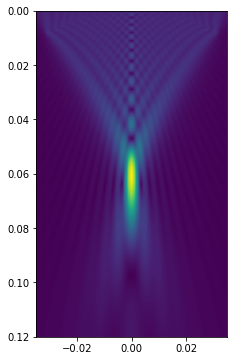

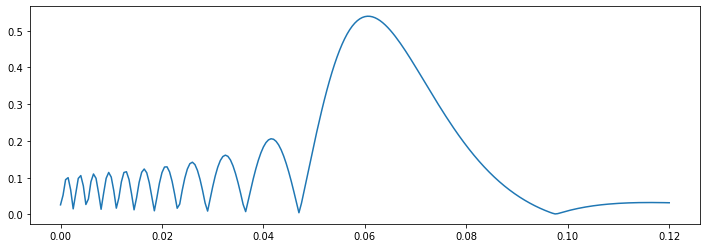

In [10]:
plt.figure(figsize=(12,6))
cy=np.argmin(np.abs(yfield))
plt.imshow(np.abs(u2[:,0,:].T),extent=(yfmin,yfmax,zfmax,zfmin))

plt.figure(figsize=(12,4))
plt.plot(zfield,np.abs(u2[cy,0,:])/1e6)



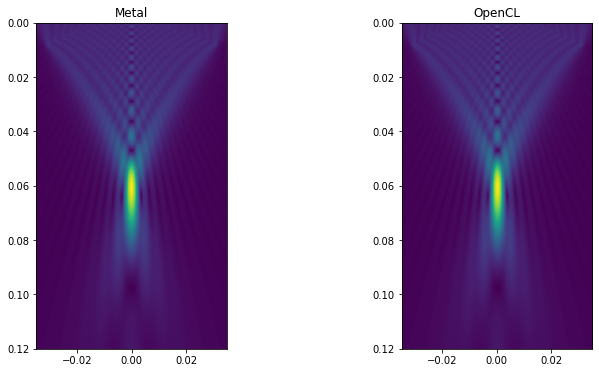

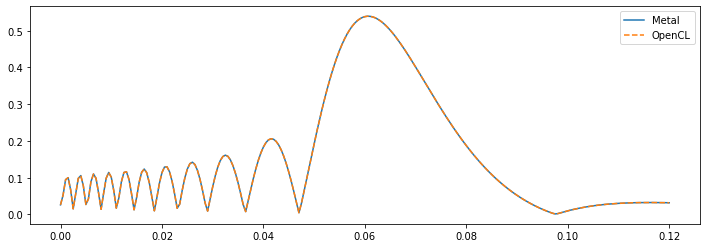

In [11]:
if platform=='darwin':
    u2o=ForwardSimple(cwvnb_extlay,Tx['center'].astype(np.float32),Tx['ds'].astype(np.float32),u0,rf,MacOsPlatform='OpenCL')
    u2o=np.reshape(u2o,xp.shape)*MediumDensity*MediumSOS #we convert back to Pa
    plt.figure(figsize=(12,6))
    cy=np.argmin(np.abs(yfield))
    plt.subplot(1,2,1)
    plt.imshow(np.abs(u2[:,0,:].T),extent=(yfmin,yfmax,zfmax,zfmin))
    plt.title('Metal')
    plt.subplot(1,2,2)
    plt.imshow(np.abs(u2o[:,0,:].T),extent=(yfmin,yfmax,zfmax,zfmin))
    plt.title('OpenCL')
    
    plt.figure(figsize=(12,4))
    plt.plot(zfield,np.abs(u2[cy,0,:])/1e6)
    plt.plot(zfield,np.abs(u2o[cy,0,:])/1e6,'--')
    plt.legend(['Metal','OpenCL'])
